# A First Look into the Himawari-8 Images

The first step of analysis is to explore the basic statistics of the Himawari-8 images.

The dimension of our dataset:
- 3300 x 3300 pixels
- 15' ~ 30'N / 114' ~ 129' E (~500m in real space)

And the data came in every 10 minutes if there is no missing.

First we use the 142 images in 2017-06-01 for a test.

In [1]:
import numpy as np
import pandas as pd

# Binary reader
def read_himawari8_btp(furi):
    ''' The method reads in a Himawari 8 image in binary format (.btp file). 
        the binary file contains 10,890,000 float point numbers (4-byte) represent 
        the brightness temperature. '''
    # Read in data
    data = np.fromfile(furi, np.float32)
    return(data.reshape((3300,3300)))

# Statistical summary
def summarize_single_image(img):
    ''' Calculate basic statistics of one Himawari-8 image. '''
    mean = np.mean(img.flatten())
    std = np.std(img.flatten())
    pt = np.percentile(img.flatten(), [0, 25, 50, 75,100])
    return({'mean':mean, 'stdev':std, 'min':pt[0],'pt25':pt[1],'median':pt[2],'pt75':pt[3], 'max':pt[4]})

# Test
tmp = read_himawari8_btp('../../data/himawari8_btp/2017-06-01_0000.B13.PCCU.btp')
print(tmp.shape)
print(summarize_single_image(tmp))

(3300, 3300)
{'mean': 269.26297, 'stdev': 24.10402, 'min': 202.0759735107422, 'pt25': 251.4745330810547, 'median': 277.27655029296875, 'pt75': 290.83428955078125, 'max': 298.4156188964844}


In [2]:
def list_himawari8_files(dir, suffix='.btp', to_remove='.B13.PCCU.btp'):
    ''' To scan through the sapecified dir and get the corresponding file with suffix. '''
    import os
    xfiles = []
    for root, dirs, files in os.walk(dir): 
        for fn in files:
            if fn.endswith(suffix): 
                 xfiles.append({'timestamp':fn.replace(to_remove,''), 'xuri':os.path.join(root, fn)})
    return(pd.DataFrame(xfiles))


xfiles = list_himawari8_files('../../data/himawari8_btp/')
print(xfiles.head())

         timestamp                                               xuri
0  2017-06-01_0000  ../../data/himawari8_btp/2017-06-01_0000.B13.P...
1  2017-06-01_0010  ../../data/himawari8_btp/2017-06-01_0010.B13.P...
2  2017-06-01_0020  ../../data/himawari8_btp/2017-06-01_0020.B13.P...
3  2017-06-01_0030  ../../data/himawari8_btp/2017-06-01_0030.B13.P...
4  2017-06-01_0040  ../../data/himawari8_btp/2017-06-01_0040.B13.P...


## Statistics per Image

We can derive basic statistics for each image, which show the trend and variations across locations in one snapshot. By applying the derivation on all images, we can see the time series of the basic statistics.



In [3]:
list_stats = []
for i in range(xfiles.shape[0]):
    row = xfiles.iloc[i,:]
    tmp = read_himawari8_btp(row['xuri'])
    stats = summarize_single_image(tmp)
    stats['timestamp'] = row['timestamp']
    list_stats.append(stats)

dfstats = pd.DataFrame(list_stats)
print(dfstats.head())

         mean      stdev         min        pt25      median        pt75  \
0  269.262970  24.104019  202.075974  251.474533  277.276550  290.834290   
1  269.255615  24.242523  203.020599  250.875427  277.430847  290.941559   
2  269.210663  24.390991  203.944473  250.184433  277.523315  291.075500   
3  269.142334  24.541594  203.638748  249.705399  277.615662  291.182526   
4  269.052887  24.682529  205.244553  249.046814  277.830811  291.289429   

          max        timestamp  
0  298.415619  2017-06-01_0000  
1  298.465576  2017-06-01_0010  
2  298.315643  2017-06-01_0020  
3  298.190552  2017-06-01_0030  
4  297.990112  2017-06-01_0040  


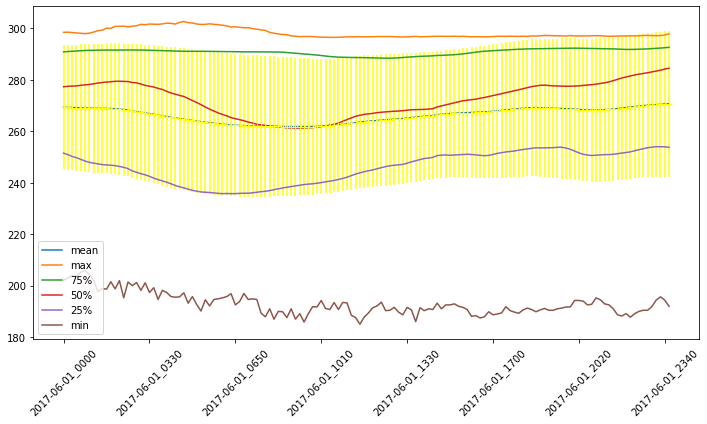

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(dfstats['mean'], label='mean')
plt.plot(dfstats['max'], label='max')
plt.plot(dfstats['pt75'], label='75%')
plt.plot(dfstats['median'], label='50%')
plt.plot(dfstats['pt25'], label='25%')
plt.plot(dfstats['min'], label='min')
plt.errorbar(np.arange(dfstats.shape[0]),dfstats['mean'],dfstats['stdev'], color='yellow', linestyle=':', marker='+')
plt.xticks(np.arange(0, dfstats.shape[0], 20), dfstats['timestamp'][np.arange(0, dfstats.shape[0], 20)], rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

### A quick look at 2017-06-01 in 10-min interval

The value we showed is the brightness temperature, and can be roughly thought as the temperature at the cloud top. The lower the value, the higher the cloud top is.

The minimal brightness temperature changed abruptly comparing to other statisitcs, which indicated the highest cloud top within the region changed relative faster. The PR-25% reached the lowest point at noon (0400UTC, 1200LST), where the PR-50% line's is around the afternoon (0700UTC, 1500LST). The variation of PR-75% is relative small. It's interesting that the PR-x lines corresponded nicely to diurnal cycles, while the PR-100% represent the solar heatiing perfectly, other PR lines showed different delays and amplifications to the cycle.



## Statistics per pixel

Another way to summarize the trends and variations of the Himawari-8 data is to see the trends and variations across time for each pixel. This approach requires more computational resoruces because we are deriving information across files. We need to either read in all data if possible, or we have to leverage the *divide-and-conquer* approach. We may also need multi-processing to speed up the analysis.

- [Pooled variance](https://en.wikipedia.org/wiki/Pooled_variance)
- [Parallel for loop over numpy matrix](https://stackoverflow.com/questions/51350640/parallel-for-loop-over-numpy-matrix)


In [16]:
# For testing , we only read the center (100,100) of the data
#import multiprocessing as mp
#ncpus = mp.cpu_count()
#print('Number of CPUs: '+str(ncpus))

def read_multiple_himawari8(flist):
    data = []
    for f in flist:
        data.append(read_himawari8_btp(f)[1600:1700,1600:1700])
    return(np.array(data))

def summarize_images_by_grid(data):
    # Get data dimension
    ni, nx, ny = data.shape
    mean_image = np.zeros((nx,ny))
    var_image = np.zeros((nx,ny))
    pr_image = np.zeros((nx,ny,5))
    #
    for i in range(nx):
        for j in range(ny):
            mean_image[i,j] = np.mean(data[:,i,j])
            var_image[i,j] = np.var(data[:,i,j])
    return({'mean':mean_image, 'variance':var_image})

def summarize_himawari8_by_grid(flist, batch_size=None):
    ''' Calculate grid-by-grid statistics of a list of Himawari-8 images. '''
    if batch_size is None:  # Read in all data
        data = read_multiple_himawari8(flist)
        summary = summarize_images_by_grid(data)
    else:                   # Read in data by batch
        pooled_mean = None
        pooled_var = None
        nSample = len(flist)
        batch_start = 0
        batch_end = batch_size
        batch_count = 0
        # Loop through all files
        while batch_start < nSample:
            print("Batch "+str(batch_count))
            limit = min(batch_end, nSample)
            data = read_multiple_himawari8(flist[batch_start:limit])
            # calculate statistics by increment
            tmp = summarize_images_by_grid(data)
            if pooled_mean is None:
                pooled_mean = (limit - batch_start)*tmp['mean']
                pooled_var = (limit - batch_start - 1)*tmp['variance']
            else:
                pooled_mean += (limit - batch_start)*tmp['mean']
                pooled_var += (limit - batch_start - 1)*tmp['variance']
            # increment
            batch_start += batch_size   
            batch_end += batch_size
            batch_count += 1
        # Pooling
        pooled_mean = pooled_mean/nSample
        pooled_var = pooled_var/(nSample-batch_count)
        summary={'mean':pooled_mean, 'variance':pooled_var}
    # 
    return(summary)

In [17]:
flist = xfiles['xuri']
tmp = summarize_himawari8_by_grid(flist, batch_size=20)

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7


In [18]:
print(tmp['mean'].shape)
print(tmp['variance'].shape)

(100, 100)
(100, 100)


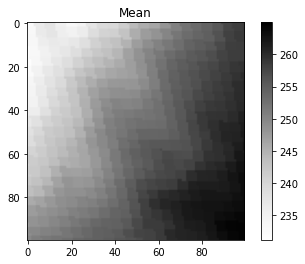

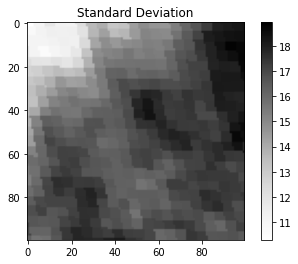

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(tmp['mean'], alpha=0.99, cmap='Greys')
plt.title('Mean')
plt.colorbar()
plt.show()

plt.imshow(np.sqrt(tmp['variance']), alpha=0.99, cmap='Greys')
plt.title('Standard Deviation')
plt.colorbar()
plt.show()

Number of CPUs: 16
6.482342599999356


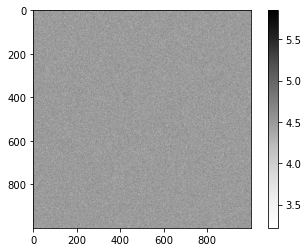

In [12]:
# Test multiprocessing
import time
import timeit
import multiprocessing as mp
ncpus = mp.cpu_count()
print('Number of CPUs: '+str(ncpus))

# Create numpy data
toy = np.random.randint(0,10,(100,1000,1000))

def average_by_dim0(data):
    ni, nx, ny = data.shape
    avgdata = np.zeros((nx,ny))
    for i in range(nx):
        for j in range(ny):
            avgdata[i,j] = np.mean(data[:,i,j])
    return(avgdata)

# Run
start = timeit.default_timer()
avgtoy = average_by_dim0(toy)
end = timeit.default_timer()
print(end - start)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(avgtoy, alpha=0.99, cmap='Greys')
plt.colorbar()
plt.show()

6.395018700000037


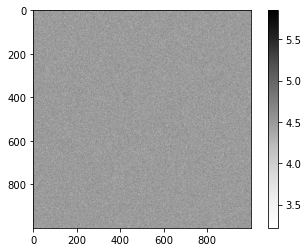

In [15]:
def average_by_dim0_mp(data):
    import multiprocessing as mp
    ni, nx, ny = data.shape
    inputs = [data[:,i,j] for i in range(nx) for j in range(ny)]
    with mp.Pool(processes=(mp.cpu_count()-2)) as pool:
        outs = pool.map(np.mean, inputs)
    return(np.array(outs).reshape((nx, ny)))

# Run
start = timeit.default_timer()
avgtoymp = average_by_dim0_mp(toy)
end = timeit.default_timer()
print(end - start)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(avgtoymp, alpha=0.99, cmap='Greys')
plt.colorbar()
plt.show()